In [29]:
from sktime.datasets import load_airline
from sklearn.metrics import mean_absolute_error
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
import pandas as pd
import os
import utils.KEprocessing
import matplotlib.pyplot as plt

In [13]:
# For the final merged dataset
final_df_path = 'data/commercial_df_2023.csv'
final_df = pd.read_csv(final_df_path, sep=',', usecols=['Dew Point Temperature_P39','Power_Consumption', 'Price', 'DateTime'])
#else:
#    final_df = utils.KEprocessing.merge_weather_price(power_df, weather_df, price_df)

In [14]:
final_df['DateTime'] = pd.to_datetime(final_df['DateTime'])
final_df.set_index('DateTime', inplace=True)

In [15]:
final_df.tail(10)

,Power_Consumption,Dew Point Temperature_P39,Price
DateTime,,,
2023-12-31 23:00:00,0.006690,4.8,29.56
2023-12-31 23:00:00,0.000047,4.8,29.56
2023-12-31 23:00:00,0.006792,4.8,29.56
2023-12-31 23:00:00,0.012027,4.8,29.56
2023-12-31 23:00:00,0.001418,4.8,29.56
2023-12-31 23:00:00,0.006591,4.8,29.56
2023-12-31 23:00:00,0.020784,4.8,29.56
2023-12-31 23:00:00,0.000412,4.8,29.56
2023-12-31 23:00:00,0.000028,4.8,29.56


# Agregate data to get all commercial consumption (sum) in Kalmar, mean price and mean temperature per day

In [16]:
# Select only the desired columns
#final_df = final_df[final_df['ISPRIVATEPERSON']=="Nej"]
#final_df_subset = final_df[['Power_Consumption', 'Price', 'Dew Point Temperature_P39']]

# Resample 'Power_Consumption' (sum) and 'Price' (average)
final_df_resampled = final_df.resample('D').agg({'Power_Consumption': 'sum', 'Price': 'mean', 'Dew Point Temperature_P39':'mean'})

In [17]:
final_df_resampled

,Power_Consumption,Price,Dew Point Temperature_P39
DateTime,,,
2023-01-01,177.335628,20.562917,4.537500
2023-01-02,215.778516,124.134167,5.416667
2023-01-03,221.203624,132.925000,0.516667
2023-01-04,227.086858,71.202917,2.675000
2023-01-05,225.075596,115.152083,-0.291667
...,...,...,...
2023-12-27,230.203512,55.553333,4.800000
2023-12-28,224.203430,35.892500,4.800000
2023-12-29,218.482716,27.819167,4.800000


# Set value to predict

In [53]:
# Resample to every hour, taking mean of values if duplicates
y = final_df_resampled
# Fill NaNs in 'Price' column of df_prophet
y['Price'] = y['Price'].fillna(0)

# Split data into train and predict

In [25]:
y_train, y_test = temporal_train_test_split(y, test_size=45)

In [ ]:
#!pip install pystan
!pip install holidays==0.24
!pip install prophet==1.1.2

## Prophet without price

In [26]:
from prophet import Prophet

forecaster = Prophet()

df_prophet = y_train.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})

forecaster.fit(df_prophet)

# Finally, when making predictions, you should also provide the 'Price' values for the respective dates
df_prophet_future = y_test.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})

13:29:26 - cmdstanpy - INFO - Chain [1] start processing
13:29:26 - cmdstanpy - INFO - Chain [1] done processing


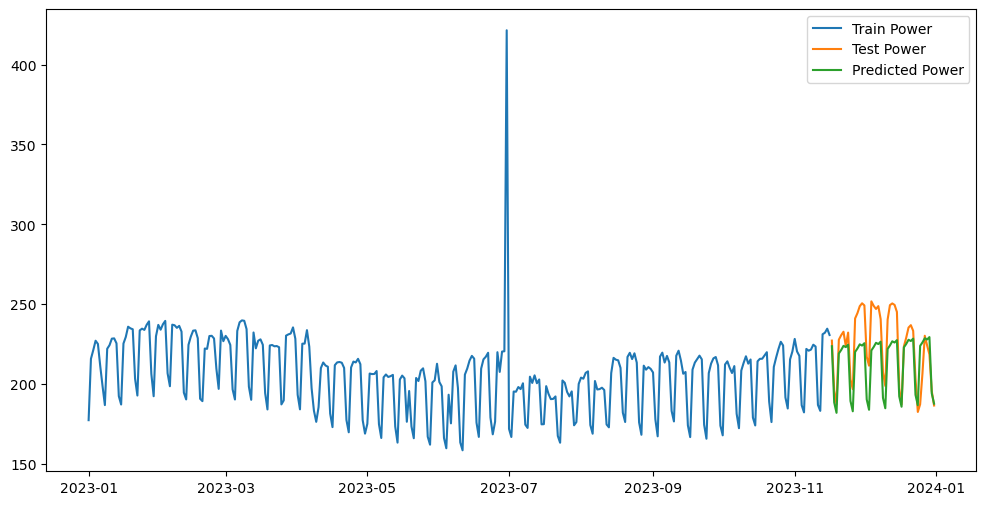

In [27]:

future_dates = y_test.reset_index()[['DateTime']]
future_dates.columns = ['ds']

y_pred = forecaster.predict(future_dates)

# Extract predictions
predictions = y_pred['yhat'][-len(y_test):]

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train.values[:, 0], label='Train Power')
plt.plot(y_test.index, y_test.values[:, 0], label='Test Power')
plt.plot(y_test.index, predictions.values, label='Predicted Power')
plt.legend(loc='best')
plt.show()


In [30]:

# Calculate predictions
predictions = y_pred['yhat']
print(len(predictions))
# Calculate actual values
actual = y_test['Power_Consumption'].values
print(len(actual))
# Calculate MAE
mae = mean_absolute_error(actual, predictions)

print(f"MAE: {mae}")

45
45
MAE: 13.934309841824627


## Prophet with price, daily and weekly seasonality

In [31]:
forecaster = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

# Add Sweden's holidays
forecaster.add_country_holidays(country_name="SE")

# Add 'Price' as a regressor
forecaster.add_regressor('Price')
forecaster.add_regressor('Dew Point Temperature_P39')
df_prophet = y_train.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})

# Fill NaNs in 'Price' column of df_prophet
df_prophet['Price'] = df_prophet['Price'].fillna(0)

print(df_prophet['Price'].isna().sum())

forecaster.fit(df_prophet)

# Finally, when making predictions, you should also provide the 'Price' values for the respective dates
df_prophet_future = y_test.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})
# Fill NaNs in 'Price' column of df_prophet
df_prophet_future['Price'] = df_prophet_future['Price'].fillna(0)
print(df_prophet_future['Price'].isna().sum())

13:31:38 - cmdstanpy - INFO - Chain [1] start processing
13:31:38 - cmdstanpy - INFO - Chain [1] done processing


0
0


In [32]:
# Create future dates and attach future 'Price' values
future_dates = y_test.reset_index()[['DateTime', 'Price','Dew Point Temperature_P39']]
future_dates.columns = ['ds', 'Price','Dew Point Temperature_P39']
future_dates['Price'] = df_prophet_future['Price']
future_dates['Price'] = future_dates['Price'].fillna(0)
future_dates['Dew Point Temperature_P39'] = df_prophet_future['Dew Point Temperature_P39']
future_dates['Dew Point Temperature_P39'] = future_dates['Dew Point Temperature_P39'].fillna(0)
y_pred = forecaster.predict(future_dates)

# Extract predictions
predictions = y_pred['yhat'][-len(y_test):]

Text(0.5, 1.0, 'Prophet with price, seasonality and temperature')

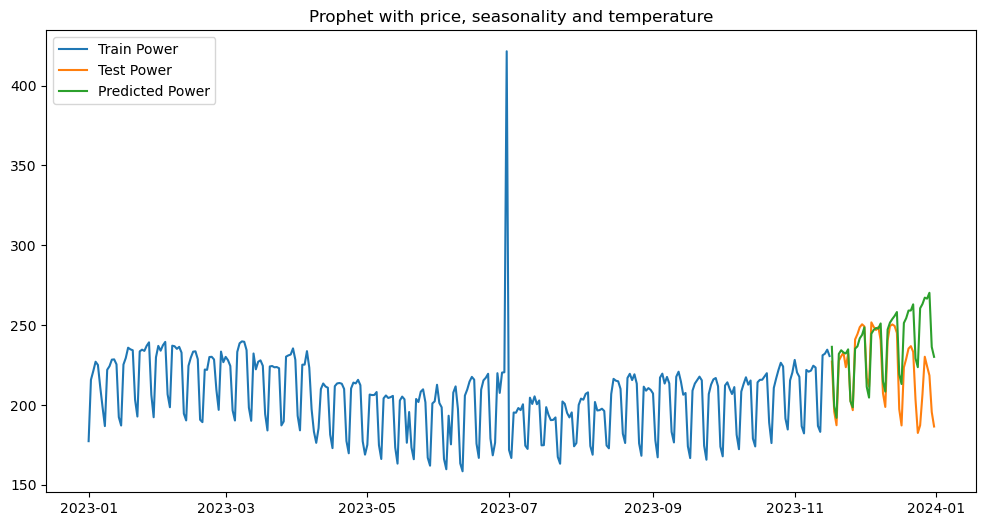

In [33]:
# Create plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train.values[:, 0], label='Train Power')
plt.plot(y_test.index, y_test.values[:, 0], label='Test Power')
plt.plot(y_test.index, predictions.values, label='Predicted Power')

plt.legend(loc='upper left')

# Create second y-axis for the prices

plt.title('Prophet with price, seasonality and temperature')
# Plot prices on second y-axis
#plt.twinx()
#plt.plot(y_train.index, df_prophet['Dew Point Temperature_P39'], color='r', label='Temp C')
#plt.plot(y_test.index, df_prophet_future['Dew Point Temperature_P39'], color='r', label='Temp C')

#plt.legend(loc='upper right')

#plt.show()


In [34]:

# Calculate predictions
predictions = y_pred['yhat']
print(len(predictions))
# Calculate actual values
actual = y_test['Power_Consumption'].values
print(len(actual))
# Calculate MAE
mae = mean_absolute_error(actual, predictions)

print(f"MAE: {mae}")

45
45
MAE: 16.422635120633156


## Prophet with price, seasonality and temperature

# Prophet with seasonality and temperature only 

In [35]:
forecaster = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

# Add Sweden's holidays
forecaster.add_country_holidays(country_name="SE")
forecaster.add_regressor('Dew Point Temperature_P39')
df_prophet = y_train.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})

forecaster.fit(df_prophet)
df_prophet_future = y_test.reset_index().rename(columns={'DateTime':'ds', 'Power_Consumption':'y'})

13:32:16 - cmdstanpy - INFO - Chain [1] start processing
13:32:16 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# Create future dates and attach future 'Price' values
future_dates = y_test.reset_index()[['DateTime', 'Dew Point Temperature_P39']]
future_dates.columns = ['ds', 'Dew Point Temperature_P39']
future_dates
future_dates['Dew Point Temperature_P39'] = df_prophet_future['Dew Point Temperature_P39']
future_dates['Dew Point Temperature_P39'] = future_dates['Dew Point Temperature_P39'].fillna(0)
y_pred = forecaster.predict(future_dates)

# Extract predictions
predictions = y_pred['yhat'][-len(y_test):]

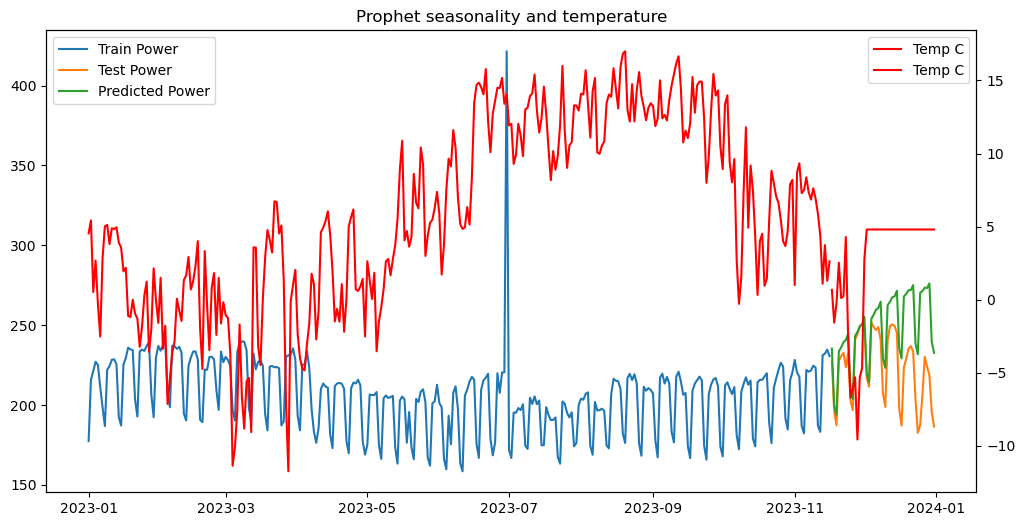

In [37]:
# Create plot
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train.values[:, 0], label='Train Power')
plt.plot(y_test.index, y_test.values[:, 0], label='Test Power')
plt.plot(y_test.index, predictions.values, label='Predicted Power')

plt.legend(loc='upper left')

# Create second y-axis for the prices

plt.title('Prophet seasonality and temperature')
# Plot prices on second y-axis
plt.twinx()
plt.plot(y_train.index, df_prophet['Dew Point Temperature_P39'], color='r', label='Temp C')
plt.plot(y_test.index, df_prophet_future['Dew Point Temperature_P39'], color='r', label='Temp C')

plt.legend(loc='upper right')

plt.show()

In [38]:

# Calculate predictions
predictions = y_pred['yhat']
print(len(predictions))
# Calculate actual values
actual = y_test['Power_Consumption'].values
print(len(actual))
# Calculate MAE
mae = mean_absolute_error(actual, predictions)

print(f"MAE: {mae}")

45
45
MAE: 23.322678560432333


# SARIMA (the simplest version without parameters)

In [39]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Creating train and test set 
train = final_df_resampled.Power_Consumption[:-45]
test = final_df_resampled.Power_Consumption[-45:]

# Fit a SARIMA(0, 1, 1)(1, 1, 1, 7) model
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(1, 1, 1, 7))

# Fit the model
model_fit = model.fit(disp=False)

# Make predictions for the last 45 observations in the dataset (this should be replaced by len(test) for your case)
predictions = model_fit.predict(len(train), len(train)+len(test)-1)

# Calculate MAE
mae = mean_absolute_error(test, predictions)

print(f"MAE: {mae}")

MAE: 12.000514256045298


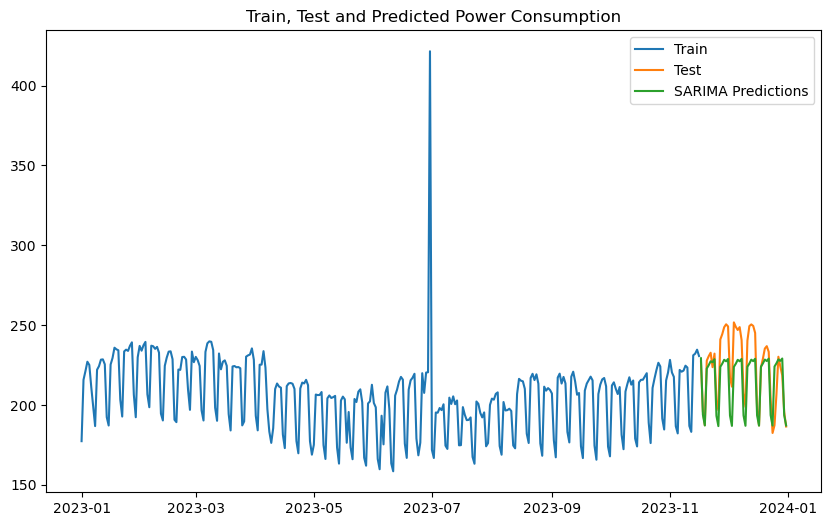

In [40]:
plt.figure(figsize=(10,6))

# Plot the training data
plt.plot(train.index, train.values, label='Train')

# Plot the testing data
plt.plot(test.index, test.values, label='Test')

# Plot the predicted data
plt.plot(test.index, predictions.values, label='SARIMA Predictions')

plt.legend(loc='best')
plt.title('Train, Test and Predicted Power Consumption')
plt.show()

# Sarimax (include temperature)

In [41]:

# Create train and test sets (using last 45 records for testing), ensuring both target and exogenous variable are included
train = final_df_resampled[:-45]
test = final_df_resampled[-45:]

# Fit a SARIMAX(0, 1, 1)x(1, 1, 1, 7) model
# Note: The last argument exog=train['Price'] adds the external variable 'Price'
model = SARIMAX(train['Power_Consumption'], order=(0, 1, 1), seasonal_order=(1, 1, 1, 7), exog=train['Dew Point Temperature_P39'])

# Fit the model
model_fit = model.fit(disp=False)

# Make predictions, include the 'Price' as an external variable again
predictions = model_fit.predict(len(train), len(train)+len(test)-1, exog=test[['Dew Point Temperature_P39']])

# Calculate MAE
mae = mean_absolute_error(test['Power_Consumption'], predictions)

print(f"MAE: {mae}")  #when price is added gets to MAE: 7.602025616045805

MAE: 12.174359707874721


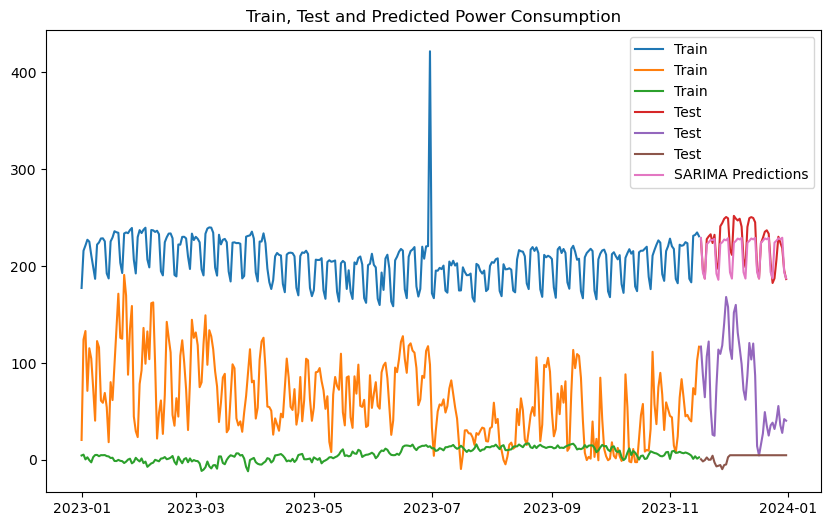

In [42]:
plt.figure(figsize=(10,6))

# Plot the training data
plt.plot(train.index, train.values, label='Train')

# Plot the testing data
plt.plot(test.index, test.values, label='Test')

# Plot the predicted data
plt.plot(test.index, predictions.values, label='SARIMA Predictions')

plt.legend(loc='best')
plt.title('Train, Test and Predicted Power Consumption')
plt.show()

# Corr matrix just to double check

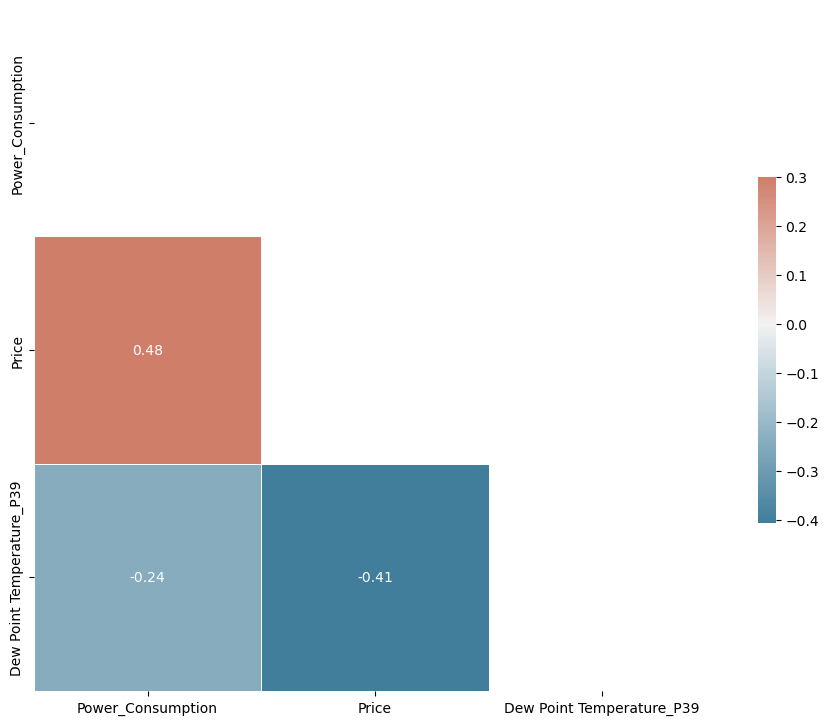

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute the correlation matrix
corr = final_df_resampled[['Power_Consumption', 'Price', 'Dew Point Temperature_P39']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

# GPT commentary regarding the results

One possible explanation could be that the relationship between 'Price' and 'Power_Consumption' is nonlinear, and the models you used (Prophet, SARIMA etc.) assume a linear relationship between the forecast variable and the exogenous regressor. It's also possible that 'Price' might be correlated with 'Power_Consumption', but not actually useful in predicting it. Remember, correlation does not imply causation. Just because two variables are correlated, doesn't mean changes in one cause changes in the other. Moreover, if 'Price' has a lot of noise (random variation) that is not related to 'Power_Consumption', this could also hurt the performance of your model. Including more variables in a model will make the model more complex, which might lead to overfitting. Overfitting happens when your model performs well on training data but performs poorly on unseen data, such as validation/test dataset. Another important point is that correlation is a measure of linear relationship. It's possible that 'Power_Consumption', 'Price' and 'Dew Point Temperature_P39' have complex nonlinear interactions that a regression model is not capturing but still increases the MAE when included. The key is to understand your variables and the domain of the problem. This might also be an indication that some other form of data pre-processing, like normalization or scaling, or more complex model is needed that can capture the relationship between 'Price' and 'Power_Consumption' more accurately. Feature selection and extraction techniques could be useful, as well as trying different predictive models (nonlinear regression, decision trees, gradient boosting, neural networks etc.), which can capture non-linear relationships between variables.